# Energy Star Score Part 2
This is part 2 of the series and we will:
- Compare several machine learning models on a performance metric
- Perform hyperparameter tuning on the best model to optimize it for the problem
- Evaluate the best model on the testing set

In [10]:
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Read in Data
Let's read in the data we formatted from the previous notebook.

In [4]:
# Read in data into dataframes 
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (6622, 64)
Testing Feature Size:   (2839, 64)
Training Labels Size:   (6622, 1)
Testing Labels Size:    (2839, 1)


In [5]:
train_features.head(12)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,99.41,NaN,NaN,NaN,NaN,6.088818,4.599253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,NaN,40.835496,-73.887745,3.0,161.0,5.384036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,NaN,40.663206,-73.949469,9.0,329.0,5.017280,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,40.622968,-74.078742,1.0,27.0,6.510853,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,28.65,40.782421,-73.972622,7.0,165.0,6.123589,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1060,2430725,182655.0,1929,1,90,52.9,9.7,0.2,4.80,40.725136,-74.004438,2.0,37.0,5.516649,1.568616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10846,5737475,65400.0,1942,1,100,66.8,3.0,0.6,67.14,40.637833,-73.973045,12.0,490.0,5.426271,4.206780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4280,2670505,113150.0,1938,1,100,78.4,5.7,NaN,30.73,40.776035,-73.964418,8.0,142.0,6.067036,3.425239,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,12974,2964670,137

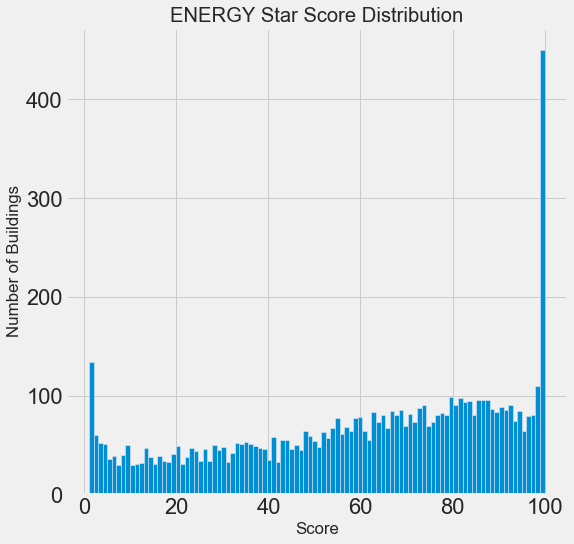

In [6]:
# Here's the distribution of the Energy Star Score.
figsize(8, 8)

# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins = 100);
plt.xlabel('Score'); plt.ylabel('Number of Buildings'); 
plt.title('ENERGY Star Score Distribution');

## Evaluating and Comparing Machine Learning Models
### Inputing Missing Values
In the code below, we create a Scikit-learn Imputer object to fill in missing values with the median of the column. Notice that we train the imputer (using the Imputer.fit method) on the training data but not the testing data. We then transform (using Imputer.transform) both the training data and testing data.

In [13]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [14]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


In [15]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


### Scaling Features
The final step to take before we can build our models is to scale the features.

In [16]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [17]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

## Models to Evaluate
We will compare five different machine learning models using the great Scikit-Learn library:
- Linear Regression
- Support Vector Machine Regression
- Random Forest Regression
- Gradient Boosting Regression
- K-Nearest Neighbors Regression

In [18]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [19]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 13.4651


In [20]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 10.9337


In [21]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 9.5231


In [22]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 10.0116


In [23]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 13.0131


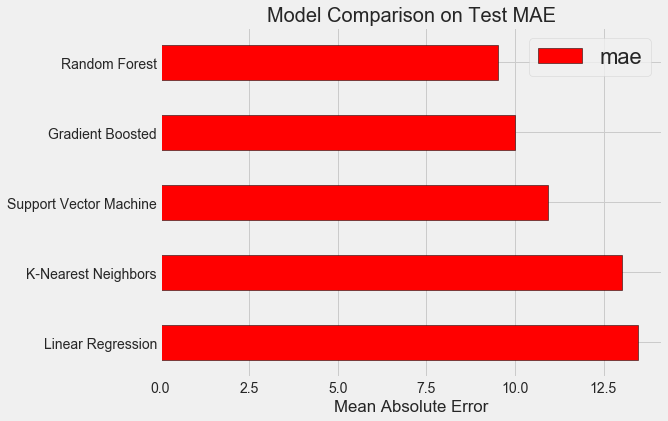

In [24]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

From here, I am going to concentrate on optimizing the best model using hyperparamter tuning. Given the results here, I will concentrate on using the GradientBoostingRegressor.
## Model Optimization
### Hyperparameters
Here we will implement random search with cross validation to select the optimal hyperparameters for the gradient boosting regressor. We first define a grid then peform an iterative process of: randomly sample a set of hyperparameters from the grid, evaluate the hyperparameters using 4-fold cross-validation, and then select the hyperparameters with the best performance.

In [25]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

For now, just know that we are trying to find the best combination of hyperparameters and because there is no theory to tell us which will work best, we just have to evaluate them, like runnning an experiment!

In the code below, we create the Randomized Search Object passing in the following parameters:
- estimator: the model
- param_distributions: the distribution of parameters we defined
- cv the number of folds to use for k-fold cross validation
- n_iter: the number of different combinations to try
- scoring: which metric to use when evaluating candidates
- n_jobs: number of cores to run in parallel (-1 will use all available)
- verbose: how much information to display (1 displays a limited amount)
- return_train_score: return the training score for each cross-validation fold
- random_state: fixes the random number generator used so we get the same results every run

The Randomized Search Object is trained the same way as any other scikit-learn model. After training, we can compare all the different hyperparameter combinations and find the best performing one.

In [26]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [27]:
# Fit on the training data
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                             

In [28]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
12,16.110786,0.079456,0.014253,1.640595e-03,500,6,6,None,5,lad,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.924621,-8.775078,-9.325044,-9.037550,-9.015573,0.201473,1,-6.934705,-6.837958,-6.869084,-6.840749,-6.870624,0.038950
3,19.040593,0.035725,0.017003,7.075617e-04,500,6,8,None,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.872066,-8.904065,-9.317120,-9.075047,-9.042074,0.176555,2,-4.384343,-4.326121,-4.823009,-4.229809,-4.440820,0.227453
9,10.568671,0.105444,0.009750,4.351505e-04,500,4,2,auto,3,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.062882,-9.043722,-9.442664,-9.153004,-9.175568,0.159633,3,-6.955777,-7.088986,-6.913108,-6.940327,-6.974550,0.067813
0,4.062660,0.038229,0.007251,4.321211e-04,100,2,6,auto,5,ls,"{'n_estimators': 100, 'min_samples_split': 2, ...",-9.100775,-9.026538,-9.456636,-9.201011,-9.196240,0.162589,4,-7.302003,-7.312645,-7.173397,-7.386171,-7.293554,0.076569
7,10.761265,0.024216,0.011002,2.665601e-07,500,4,6,auto,3,ls,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.147703,-9.199444,-9.698622,-9.358627,-9.351099,0.215173,5,-7.089709,-7.103749,-7.021418,-7.080088,-7.073741,0.031358
19,22.422338,0.162656,0.015503,8.662381e-04,1100,6,2,auto,3,lad,"{'n_estimators': 1100, 'min_samples_split': 6,...",-9.350800,-9.382812,-9.475236,-9.291753,-9.375150,0.066377,6,-8.513004,-8.658903,-7.820534,-8.017995,-8.252609,0.344461
10,70.596841,0.165786,0.071019,3.313801e-03,1100,10,6,None,10,huber,"{'n_estimators': 1100, 'min_samples_split': 10...",-9.310569,-9.221542,-9.607417,-9.406728,-9.386564,0.143344,7,-0.367238,-0.448288,-0.380887,-0.383469,-0.394971,0.031394
2,44.970010,0.608965,0.057764,1.520877e-02,500,4,2,auto,10,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.464847,-9.250544,-9.524215,-9.427327,-9.416733,0.101979,8,-0.159369,-0.158543,-0.129798,-0.143705,-0.147854,0.012146
16,27.522020,0.103633,0.025755,4.328095e-04,1500,4,6,None,3,ls,"{'n_estimators': 1500, 'min_samples_split': 4,...",-9.248455,-9.315932,-9.797820,-9.427920,-9.447532,0.212154,9,-4.821677,-4.876202,-4.776650,-4.729506,-4.801009,0.054284
21,3.972902,0.037702,0.017505,8.661691e-04,500,6,4,log2,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-9.365194,-9.286988,-9.751767,-9.409179,-9.453282,0.177800,10,-5.733003,-5.742441,-5.571781,-5.666476,-5.678425,0.068177


In [29]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='lad', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

The best gradient boosted model has the following hyperparameters:
- loss = lad
- n_estimators = 500
- max_depth = 5
- min_samples_leaf = 6
- min_samples_split = 6
- max_features = None (This means that max_features = n_features according to the docs)

Here we will use grid search with a grid that only has the n_estimators hyperparameter. We will evaluate a range of trees then plot the training and testing performance to get an idea of what increasing the number of trees does for our model. We will fix the other hyperparameters at the best values returned from random search to isolate the number of trees effect.

In [30]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss = 'lad', max_depth = 5,
                                  min_samples_leaf = 6,
                                  min_samples_split = 6,
                                  max_features = None,
                                  random_state = 42)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [31]:
# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.1min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='lad', max_depth=5,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=6,
                                                 min_samples_split=6,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                

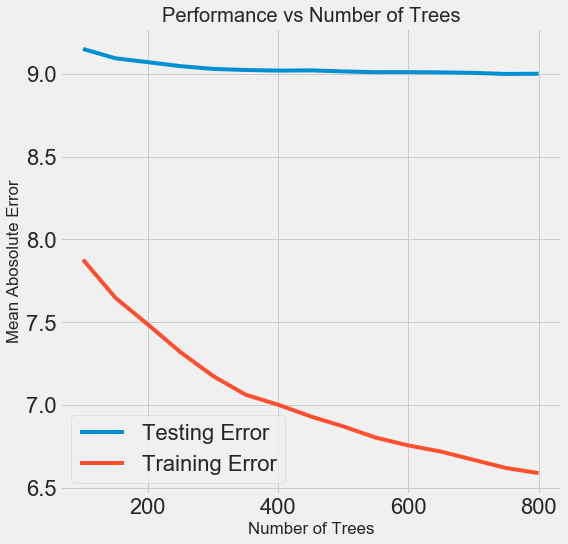

In [32]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [33]:
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
13,26.779453,0.110918,0.020254,0.001300,750,{'n_estimators': 750},-8.901092,-8.751699,-9.298411,-9.049730,-9.000233,0.201840,1,-6.716494,-6.660453,-6.520818,-6.579989,-6.619438,0.074807
14,25.085141,0.196665,0.016253,0.001300,800,{'n_estimators': 800},-8.903857,-8.758299,-9.296941,-9.047485,-9.001645,0.198797,2,-6.689643,-6.648109,-6.486269,-6.530287,-6.588577,0.083101
12,25.171050,0.062464,0.019753,0.000433,700,{'n_estimators': 700},-8.904269,-8.755862,-9.312990,-9.053755,-9.006719,0.205815,3,-6.743886,-6.695770,-6.611240,-6.624919,-6.668953,0.053861
11,23.415108,0.055209,0.018754,0.000829,650,{'n_estimators': 650},-8.906208,-8.755401,-9.325190,-9.052215,-9.009754,0.210191,4,-6.778068,-6.721452,-6.708191,-6.666758,-6.718617,0.039814
9,19.710267,0.064016,0.016504,0.000499,550,{'n_estimators': 550},-8.918502,-8.756938,-9.325492,-9.042721,-9.010913,0.207975,5,-6.874737,-6.781878,-6.809121,-6.745712,-6.802862,0.047201


It appears out mode is overfitting. The training error is significantly lower than the testing error, which shows that the model is learning the training data very well but then is not able to generalize to the test data as well. Moveover, as the number of trees increases, the amount of overfitting increases. Both the test and training error decrease as the number of trees increase but the training error decreases more rapidly. 

Based on the cross validation results, the best model using 800 trees and achieves a cross validation error under 9. This indicates that the average cross-validation estimate of the Energy Star Score is within 9 points of the true answer!

## Evaluate Final Model on the Test Set
We will use the best model from hyperparameter tuning to make predictions on the testing set. Remember, our model has never seen the test set before, so this performance should be a good indicator of how the model would perform if deployed in the real world.

For comparison, we can also look at the performance of the default model. The code below creates the final model, trains it (with timing), and evaluates on the test set.

In [34]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='lad', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=750,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [35]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

2.71 s ± 627 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [36]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

26.1 s ± 1.83 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [37]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 10.0119.
Final model performance on the test set:   MAE = 9.0474.


The final model does out-perform the baseline model by about 10%, but at the cost of significantly increased running time. To get a sense of the predictions, we can plot the distribution of true values on the test set and the predicted values on the test set.

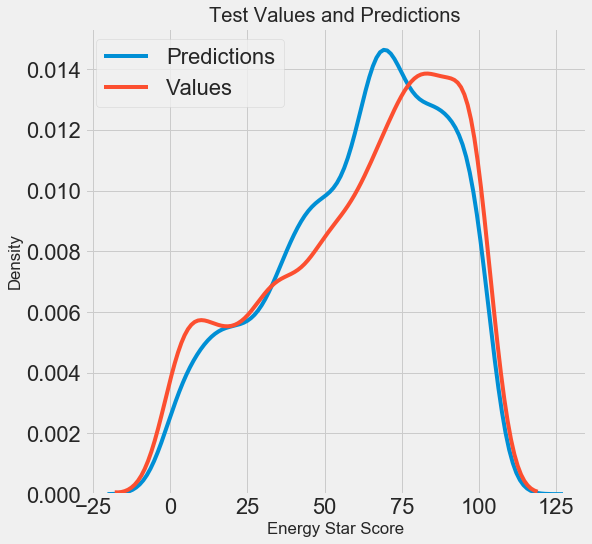

In [38]:
figsize(8, 8)

# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

The distribution looks to be nearly the same although the density of the predicted values is closer to the median of the test values rather than to the actual peak at 100. It appears the model might be less accurate at predicting the extreme values and instead predicts values closer to the median.

Another diagnostic plot is a histogram of the residuals. Ideally, we would hope that the residuals are normally distributed, meaning that the model is wrong the same amount in both directions (high and low).

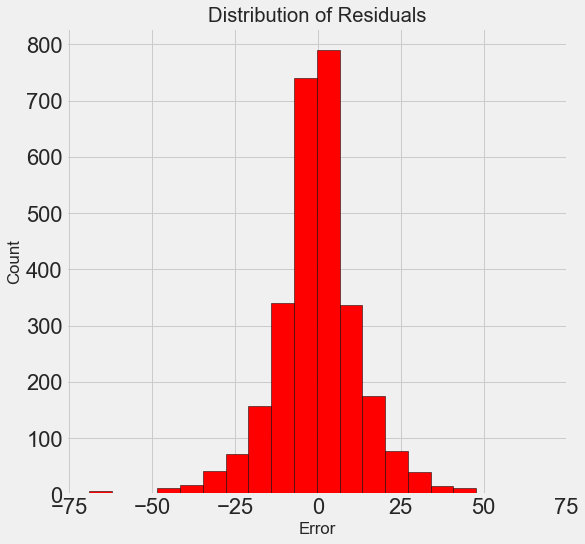

In [39]:
figsize = (6, 6)

# Calculate the residuals 
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals');

The residuals are close to normally disributed, with a few noticeable outliers on the low end. These indicate errors where the model estimate was far below that of the true value.

## Conclusions
The results showed us that machine learning is applicable to our problem, with the final model able to the predict the Energy Star Score of a building to within 9.1 points. We also saw that hyperparamter tuning was able to improve the performance of the model although at a considerable cost in terms of time invested. This is a good reminder that proper feature engineering and gathering more data (if possible!) has a much larger pay-off than fine-tuning the model. We also observed the trade-off in run-time versus accuracy, which is one of many considerations we have to take into account when designing machine learning models.

We know our model is accurate, but do we know why it makes the predictions it does? The next step in the machine learning process is crucial: trying to understand how the model makes predictions. Achieveing high accuracy is great, but it would also be helpful if we could figure out why the model is able to predict accurately so we could use this information to better understand the problem. For example, what features does the model rely on to infer the Energy Star Score? It is possible to use this model for feature selection and implement a simpler model that is more interpretable?